[*********************100%***********************]  5 of 5 completed


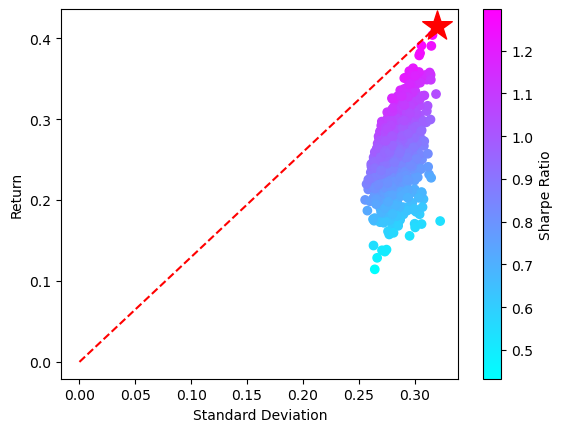

In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Define the list of stocks to include in the portfolio
tickers = ['AAPL', 'CAT', 'DIS', 'KO', 'META']

# Get historical stock data for the tickers
data = yf.download(tickers, start="2020-01-01", end="2021-12-31")['Adj Close']

# Calculate daily returns for each stock
returns = data.pct_change().dropna()

# Define the number of Monte Carlo simulations to run
num_simulations = 1000

# Define the number of trading days in a year
num_trading_days = 252

# Create an array to hold the simulation results
results = np.zeros((num_simulations, len(tickers)+2))

# Generate random weights for each stock in each simulation
for i in range(num_simulations):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    
    # Calculate the annualized returns and standard deviations of the portfolio
    portfolio_return = np.sum(returns.mean() * weights) * num_trading_days
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * num_trading_days, weights)))
    
    # Store the annualized returns and standard deviations for the portfolio
    results[i,:] = [portfolio_return, portfolio_std_dev] + list(weights)

# Convert the results to a DataFrame
columns = ['Return', 'Std Dev'] + tickers
df = pd.DataFrame(results, columns=columns)

# Find the portfolio with the highest Sharpe ratio
max_sharpe_idx = df['Return'] / df['Std Dev']
max_sharpe_idx = max_sharpe_idx.idxmax()

# Get the weights for the optimal portfolio
optimal_weights = df.iloc[max_sharpe_idx, 2:].values

# Calculate the annualized returns and standard deviation of the optimal portfolio
optimal_return = df.iloc[max_sharpe_idx, 0]
optimal_std_dev = df.iloc[max_sharpe_idx, 1]

# Plot the results
plt.scatter(df['Std Dev'], df['Return'], c=df['Return'] / df['Std Dev'], marker='o', cmap='cool')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Return')
plt.scatter(optimal_std_dev, optimal_return, marker='*', s=500, c='r')
plt.plot([0, optimal_std_dev], [0, optimal_return], 'r--')
plt.show()


In [21]:
cov_matrix

array([[5.62077643e-04, 3.06015821e-04, 2.06128478e-04, 1.89765224e-04,
        4.85480136e-04],
       [3.06015821e-04, 4.21061150e-04, 9.31054346e-05, 8.93052453e-05,
        3.83054198e-04],
       [2.06128478e-04, 9.31054346e-05, 5.35038587e-04, 2.25218916e-04,
        2.43207399e-04],
       [1.89765224e-04, 8.93052453e-05, 2.25218916e-04, 3.01084369e-04,
        2.02137191e-04],
       [4.85480136e-04, 3.83054198e-04, 2.43207399e-04, 2.02137191e-04,
        1.53517834e-03]])

Mean Squared Error: 65.82432455392969


C:\Users\Giorg\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


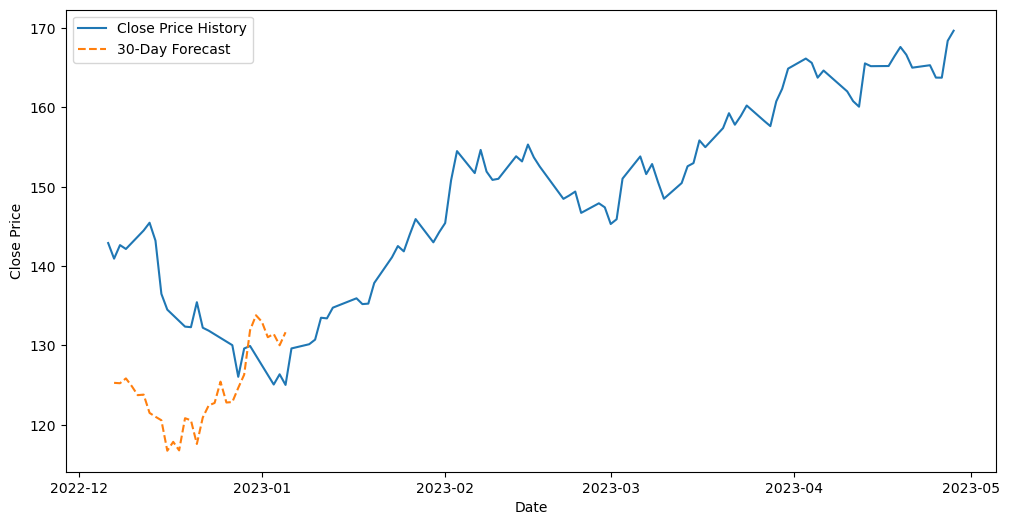

In [16]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to scrape financial data
def scrape_financial_data(ticker):
    url = f"https://finance.yahoo.com/quote/{ticker}/history?p={ticker}"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    # Extract table data
    table_data = []
    for row in soup.find_all("tr"):
        columns = row.find_all("td")
        if len(columns) == 7:
            date = columns[0].text
            close_price = float(columns[4].text.replace(",", ""))
            table_data.append([date, close_price])

    # Convert to a pandas DataFrame
    df = pd.DataFrame(table_data, columns=["Date", "Close"])
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    return df

def forecast_financial_data(df, forecast_days=30):
    # Prepare data for the model
    df["Prediction"] = df[["Close"]].shift(-forecast_days)
    X = df.drop("Prediction", axis=1)[:-forecast_days]
    y = df["Prediction"][:-forecast_days]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Create and train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    # Forecast for the next 30 days
    last_date = df.index[-1]
    future_dates = pd.date_range(last_date, periods=forecast_days + 1)[1:]
    forecast_set = df["Close"][-forecast_days:]
    forecast = model.predict(forecast_set.values.reshape(-1, 1))

    return future_dates, forecast


def main():
    ticker = "AAPL"  # Apple Inc.
    df = scrape_financial_data(ticker)
    future_dates, forecast = forecast_financial_data(df)

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["Close"], label="Close Price History")
    plt.plot(future_dates, forecast, label="30-Day Forecast", linestyle="--")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed
Mean Squared Error: 6.493755619760814


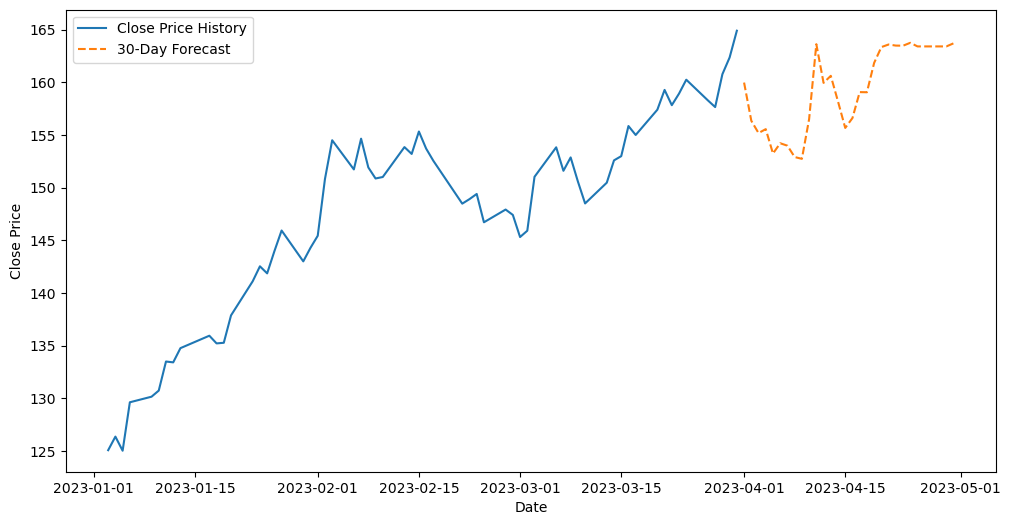

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to get stock data
def get_stock_data(ticker, start, end):
    stock_data = yf.download(ticker, start=start, end=end)
    return stock_data

# Function to compute a forecast using scikit-learn RandomForestRegressor
def forecast_stock_data(df, forecast_days=30):
    # Prepare data for the model
    df["Prediction"] = df[["Close"]].shift(-forecast_days)
    X = df.drop("Prediction", axis=1)[:-forecast_days]
    y = df["Prediction"][:-forecast_days]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Create and train the RandomForestRegressor model
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    # Forecast for the next 30 days
    last_date = df.index[-1]
    future_dates = pd.date_range(last_date, periods=forecast_days + 1)[1:]
    forecast_set = df.drop("Prediction", axis=1)[-forecast_days:]
    forecast = model.predict(forecast_set)

    return future_dates, forecast

# Main function to run the script
def main():
    ticker = "AAPL"  # Apple Inc.
    start = "2023-01-01"
    end = "2023-04-01"

    df = get_stock_data(ticker, start, end)
    future_dates, forecast = forecast_stock_data(df)

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["Close"], label="Close Price History")
    plt.plot(future_dates, forecast, label="30-Day Forecast", linestyle="--")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed
Mean Squared Error: 0.5670921673212919


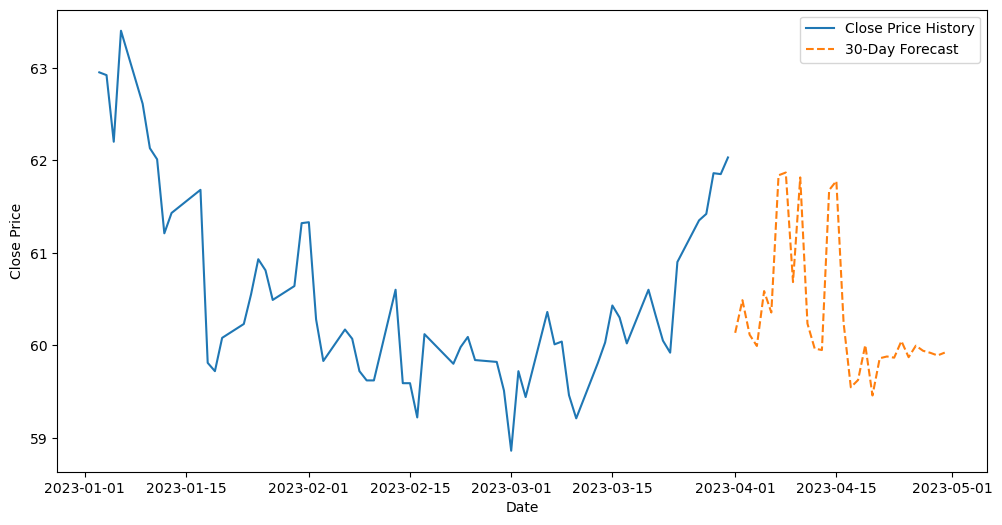

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to get stock data
def get_stock_data(ticker, start, end):
    stock_data = yf.download(ticker, start=start, end=end)
    return stock_data

# Function to compute a forecast using scikit-learn RandomForestRegressor
def forecast_stock_data(df, forecast_days=30):
    # Prepare data for the model
    df["Prediction"] = df[["Close"]].shift(-forecast_days)
    X = df.drop("Prediction", axis=1)[:-forecast_days]
    y = df["Prediction"][:-forecast_days]

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Create and train the RandomForestRegressor model
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    # Forecast for the next 30 days
    last_date = df.index[-1]
    future_dates = pd.date_range(last_date, periods=forecast_days + 1)[1:]
    forecast_set = df.drop("Prediction", axis=1)[-forecast_days:]
    forecast = model.predict(forecast_set)

    return future_dates, forecast

# Main function to run the script
def main():
    ticker = "KO"  # Apple Inc.
    start = "2023-01-01"
    end = "2023-04-01"

    df = get_stock_data(ticker, start, end)
    future_dates, forecast = forecast_stock_data(df)

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["Close"], label="Close Price History")
    plt.plot(future_dates, forecast, label="30-Day Forecast", linestyle="--")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
